# Data Scientist Coding Challenge

This is an open-ended assessment which gives you a chance to demonstrate:
- expertise in machine learning tools and techniques
- proficiency with standard geospatial analysis toolsets
- creativity and ability to quickly prototype a solution

We have provided you with a 70-year sample dataset of several climate variables from the ERA5 reanalysis. The data are reprocessed to weekly resolution on a 1&deg; grid. Your assignment is to:
- extract a timeseries of precipitation in Medellín, Colombia
- build a machine learning predictive model for rainfall one month in advance 
- test and analyze its predictive performance by applying it to out of sample data

You should aim for the most predictive model you can. If you are not done after two hours, it is OK to submit a partial answer.

There is no GPU attached to this notebook environment, so keep the ML simple if you choose that route.

In [128]:
# Some useful libraries available in this environment
import xarray as xr
import pandas as pd
import numpy as np
from eofs.xarray import Eof
import xesmf as xe
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn as sk
import xskillscore as xs

In [129]:
# Open the example dataset for this assignment from cloud storage
# * precip = rainfall (this is what we are going to predict)
# * mslp = mean sea level pressure
# * olr = outgoing longwave (thermal) radiation
# * sst = sea surface temperature
# * temp = temperature
ds = xr.open_zarr('gs://salient-toy-data/sample_dataset')
ds

,Array,Chunk
Bytes,902.75 MiB,1.37 MiB
Shape,"(3652, 180, 360)","(100, 60, 60)"
Count,667 Tasks,666 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,902.75 MiB,1.37 MiB
Shape,"(3652, 180, 360)","(100, 60, 60)"
Count,667 Tasks,666 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


# Example: Linear Regression

We will generate a simple forecast of rainfall in Medellín, Colombia for the month using the data available to us.  Rainfall in equatorial South America is strongly influenced by reduced convective activity during El Nino (La Nina) events, so we expect a negative correlation here.

array(0.44113087)

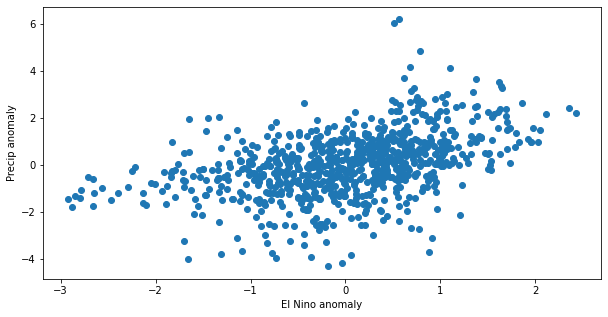

In [130]:
# Calculate monthly anomalies by subtracting historical averages
ds_monthly = ds.resample(time='MS').mean()
ds_anom = ds_monthly.groupby('time.month') - ds_monthly.groupby('time.month').mean()

# We want to forecast precip in Medellin, Colombia
precip = ds_anom.precip.sel(lon=-75, lat=6, method='nearest')
precip_target = precip.rolling(time=3, min_periods=1).mean().shift(time=-2).compute()
#Changed the name of this variable to "target" to differentiate from precip predictor, defined later

# Calculate the el nino index for the surrounding region
nino = -ds_anom.sst.sel(lon=slice(-170, -120), lat=slice(-5, 5)).mean(['lat', 'lon'])
# Predict based on last month's el nino index
nino_predictor = nino.shift(time=-1).compute()

# Eye test to see how well these properties are correlated
plt.figure(figsize=[10, 5])
ax = plt.subplot(1,1,1)
plt.scatter(nino_predictor, precip_target)
plt.xlabel('El Nino anomaly')
plt.ylabel('Precip anomaly')

# Correlation is ok, but not great:
xs.pearson_r(precip_target, nino_predictor, dim='time', skipna=True).values

0.16460759918689227

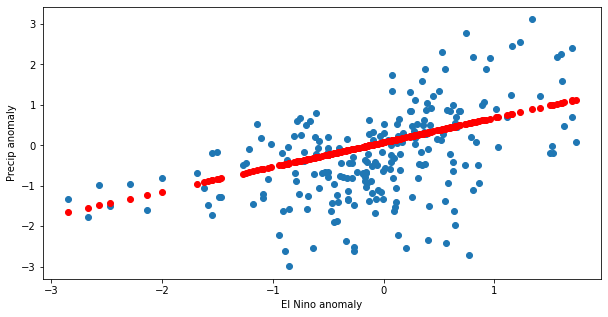

In [131]:
# First let's try a simple linear regression model
from sklearn.linear_model import LinearRegression
# Hold out recent data so we can test out-of-sample later
train_sample = slice('1951-01-01', '1998-12-01')
outof_sample = slice('2000-01-01', '2018-12-01')
fit = LinearRegression().fit(
    nino_predictor.sel(time=train_sample).values[:,None],
    precip_target.sel(time=train_sample).values[:,None])

nino_oos = nino_predictor.sel(time = outof_sample).values[:,None]
precip_oos = precip_target.sel(time = outof_sample).values[:,None]

# visualize the result:
plt.figure(figsize=[10, 5])
ax = plt.subplot(1,1,1)
plt.scatter(nino_oos, precip_oos)
plt.scatter(nino_oos, fit.predict(nino_oos), c = 'red')
plt.xlabel('El Nino anomaly')
plt.ylabel('Precip anomaly')

# our r^2 "goodness of fit" is not very good 
fit.score(nino_oos, precip_oos)

# Task 1: Build a better model

There is some signal here, but also quite a bit of noise.  As a data scientist, you can do better than this.  What techniques might you use?

You may use other parameters as needed to enhance your model, but beware overfitting.

In [132]:
#Build a better model
#Bring in outoing longwave radiation, temperature, and precipitation of previous month as additional predictors
#Will test against another simple linear regression model to see effect of additional feautres

longwave = ds_anom.olr.sel(lon=-75, lat=6, method='nearest')
longwave_predictor = longwave.shift(time=-1).compute()

temp = ds_anom.temp.sel(lon=-75, lat=6, method='nearest')
temp_predictor = temp.shift(time=-1).compute()

#Bring in precipitation of previous month as a predictor as well
precip_predictor = precip.shift(time=-1).compute()

In [133]:
#Concat all four predictors in same matrix
xt = xr.concat((precip_predictor, nino_predictor, longwave_predictor, temp_predictor), 
               dim = 'new_dim', coords='minimal').transpose()
xt.shape

(840, 4)

r^2 score:  0.5133789761908998
211.9 % improvement over one-feature LR model


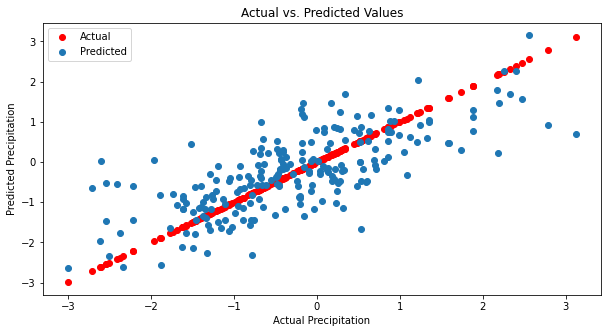

In [134]:
#Test same linear regression model but using the four predictors this time to predict precipitation
from sklearn.metrics import r2_score

fit_4 = LinearRegression().fit(
    xt.sel(time=train_sample).values[:,:],
    precip_target.sel(time=train_sample).values[:,None])

xt_oos = xt.sel(time = outof_sample).values[:,:]
precip_oos = precip_target.sel(time = outof_sample).values[:,None]

# visualize the result:
plt.figure(figsize=[10, 5])
ax = plt.subplot(1,1,1)
plt.scatter(precip_oos, precip_oos, c = 'red')
plt.scatter(precip_oos, fit_4.predict(xt_oos))
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Precipitation')
plt.ylabel('Predicted Precipitation')
plt.legend(labels = ['Actual', 'Predicted'])

r2_scor = r2_score(precip_oos, fit_4.predict(xt_oos))
print('r^2 score: ', r2_scor)
print(np.round(100*(r2_scor/(fit.score(nino_oos, precip_oos))-1), decimals = 1), '% improvement over one-feature LR model')

## ANN Model

In [135]:
#Build a Artificial Neural Network to achieve a better model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, SimpleRNN, LSTM
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [136]:
#Normalize inputs and standardize outputs to help model converge. This model will have same inputs as last
#linear regression model

cs = StandardScaler()
mm = MinMaxScaler(feature_range=(-1,1))

X_train = xt.sel(time= train_sample).values[:,:]
X_test = xt.sel(time = outof_sample).values[:,:]
X_train = mm.fit_transform(X_train)
X_test = mm.transform(X_test)

y_train = precip_target.sel(time=train_sample).values[:,None]
y_test = precip_target.sel(time=outof_sample).values[:,None]
y_train = cs.fit_transform(y_train)
y_test = cs.transform(y_test)

y_test_ann = y_test

In [137]:
#Build out model
ann = Sequential()

ann.add(Dense(10, activation='tanh'))

ann.add(Dense(5, activation='relu'))

ann.add(Dense(1, activation='linear'))

# Compile model
ann.compile(loss='mse', optimizer= 'Adam', metrics= 'mse')

In [138]:
#Fit and run model
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 10)

ann.fit(x=X_train, 
          y=y_train, 
          epochs=200,
          batch_size=8,
          validation_data=(X_test, y_test), 
          callbacks = [early_stop]
          )

Epoch 1/200
72/72 [==============================] - 1s 4ms/step - loss: 0.5755 - mse: 0.5755 - val_loss: 0.3916 - val_mse: 0.3916
Epoch 2/200
72/72 [==============================] - 0s 2ms/step - loss: 0.4510 - mse: 0.4510 - val_loss: 0.3674 - val_mse: 0.3674
Epoch 3/200
72/72 [==============================] - 0s 2ms/step - loss: 0.4151 - mse: 0.4151 - val_loss: 0.3771 - val_mse: 0.3771
Epoch 4/200
72/72 [==============================] - 0s 2ms/step - loss: 0.4058 - mse: 0.4058 - val_loss: 0.3727 - val_mse: 0.3727
Epoch 5/200
72/72 [==============================] - 0s 2ms/step - loss: 0.4007 - mse: 0.4007 - val_loss: 0.3715 - val_mse: 0.3715
Epoch 6/200
72/72 [==============================] - 0s 2ms/step - loss: 0.3968 - mse: 0.3968 - val_loss: 0.3702 - val_mse: 0.3702
Epoch 7/200
72/72 [==============================] - 0s 2ms/step - loss: 0.3927 - mse: 0.3927 - val_loss: 0.3646 - val_mse: 0.3646
Epoch 8/200
72/72 [==============================] - 0s 2ms/step - loss: 0.3897 - m

In [139]:
losses = pd.DataFrame(ann.history.history)

<AxesSubplot:>

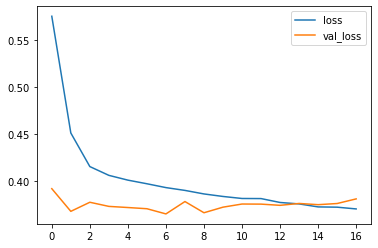

In [140]:
#Plot out losses vs. epochs
losses[['loss','val_loss']].plot()

8/8 [==============================] - 0s 1ms/step
Test r^2 score:  0.49568388347424286


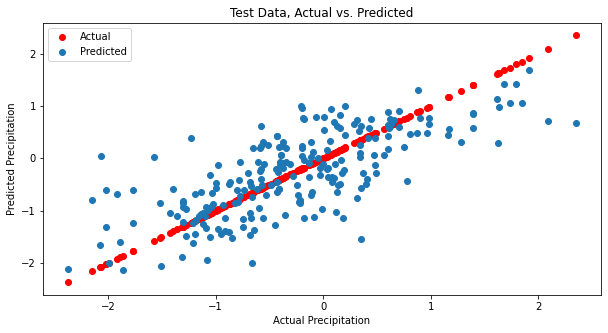

In [141]:
# Visualizing the results of actual vs. predicted precipitation
y_pred_ann = ann.predict(X_test)

plt.figure(figsize=[10, 5])
ax = plt.subplot(1,1,1)
plt.scatter(y_test, y_test, c = 'red')
plt.scatter(y_test, y_pred_ann)
plt.title('Test Data, Actual vs. Predicted')
plt.xlabel('Actual Precipitation')
plt.ylabel('Predicted Precipitation')
plt.legend(labels = ['Actual', 'Predicted'])

#Not really an improvement over the last linear regression model
print('Test r^2 score: ', r2_score(y_test, y_pred_ann))

## Prep look back window for testing with Simple RNN and LSTM models

In [142]:
#We will build a "look back" window over the last 24 months of the four factors as input to predict the 
#precipitation of the next month

#Function to prep data in windows for prediction
def convert2windows(Predictors, target, look_back):
    X, Y =[], []
    for i in range(len(target)-look_back):
        d=i+look_back  
        X.append(Predictors[i:d,:])
        Y.append(target[(d-1),0]) #The "-" here is to account for the fact that precipitation data is already shifted forward
    return np.array(X), np.array(Y)

In [143]:
# setup look_back window 
look_back = 24

X_train, y_train = convert2windows(X_train, y_train, look_back)
X_test, y_test = convert2windows(X_test, y_test, look_back)

In [144]:
#Reshape to ready for input into models

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[2], X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[2], X_test.shape[1]))

## Simple RNN

In [145]:
#Build simple RNN model using window data. Expectation is that RNN will perform better with sequential data.

#RNN Model

rnn=Sequential()

rnn.add(SimpleRNN(units=50, input_shape = (X_test.shape[1], look_back), activation='tanh'))

rnn.add(Dense(10, activation='relu'))

rnn.add(Dense(1, activation = 'linear'))

rnn.compile(loss='mse',  optimizer='adam',metrics = ['mse'])

In [146]:
early_stop = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 10)

rnn.fit(x=X_train, 
          y=y_train, 
          epochs=200,
          batch_size= look_back,
          validation_data=(X_test, y_test), 
          callbacks = [early_stop],
          shuffle = False
          )

Epoch 1/200
23/23 [==============================] - 1s 12ms/step - loss: 0.9693 - mse: 0.9693 - val_loss: 0.5119 - val_mse: 0.5119
Epoch 2/200
23/23 [==============================] - 0s 3ms/step - loss: 0.5649 - mse: 0.5649 - val_loss: 0.3809 - val_mse: 0.3809
Epoch 3/200
23/23 [==============================] - 0s 3ms/step - loss: 0.4290 - mse: 0.4290 - val_loss: 0.3085 - val_mse: 0.3085
Epoch 4/200
23/23 [==============================] - 0s 4ms/step - loss: 0.3406 - mse: 0.3406 - val_loss: 0.2637 - val_mse: 0.2637
Epoch 5/200
23/23 [==============================] - 0s 4ms/step - loss: 0.2861 - mse: 0.2861 - val_loss: 0.2417 - val_mse: 0.2417
Epoch 6/200
23/23 [==============================] - 0s 3ms/step - loss: 0.2461 - mse: 0.2461 - val_loss: 0.2219 - val_mse: 0.2219
Epoch 7/200
23/23 [==============================] - 0s 3ms/step - loss: 0.2179 - mse: 0.2179 - val_loss: 0.2106 - val_mse: 0.2106
Epoch 8/200
23/23 [==============================] - 0s 3ms/step - loss: 0.1960 - 

<AxesSubplot:>

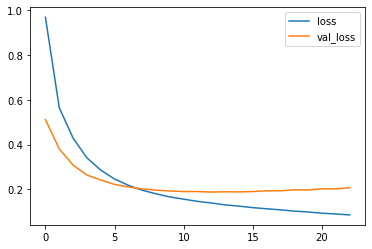

In [147]:
losses = pd.DataFrame(rnn.history.history)
#Plot out losses vs. epochs. Training and validation loss are close to each other, indicating lack of overfitting
losses[['loss','val_loss']].plot()

7/7 [==============================] - 0s 2ms/step
Test r^2 score:  0.7316696824961194


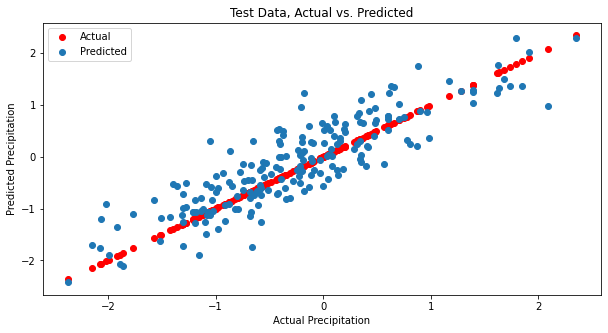

In [148]:
# Visualizing the results of actual vs. predicted precipitation
y_pred_t = rnn.predict(X_train)

plt.figure(figsize=[10, 5])

y_pred_rnn = rnn.predict(X_test)
ax = plt.subplot(1,1,1)
plt.scatter(y_test, y_test, c = 'red')
plt.scatter(y_test, y_pred_rnn)
plt.title('Test Data, Actual vs. Predicted')
plt.xlabel('Actual Precipitation')
plt.ylabel('Predicted Precipitation')
plt.legend(labels = ['Actual', 'Predicted'])


#R^2 score has improved
print('Test r^2 score: ', r2_score(y_test, y_pred_rnn))

## LSTM Model

In [149]:
# Setup model
lstm =Sequential()

lstm.add(LSTM(units=50, input_shape = (X_test.shape[1], look_back), activation='tanh'))

lstm.add(Dense(10, activation='relu'))

lstm.add(Dense(1, activation = 'linear'))

lstm.compile(loss='mse',  optimizer='adam',metrics = ['mse'])

In [150]:
#Fit data

early_stop = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 10)

lstm.fit(x=X_train, 
          y=y_train, 
          epochs=200,
          batch_size= look_back,
          validation_data=(X_test, y_test), 
          callbacks = [early_stop],
          shuffle = False
          )

Epoch 1/200
23/23 [==============================] - 2s 25ms/step - loss: 0.9996 - mse: 0.9996 - val_loss: 0.7244 - val_mse: 0.7244
Epoch 2/200
23/23 [==============================] - 0s 5ms/step - loss: 0.9066 - mse: 0.9066 - val_loss: 0.6641 - val_mse: 0.6641
Epoch 3/200
23/23 [==============================] - 0s 5ms/step - loss: 0.8179 - mse: 0.8179 - val_loss: 0.6174 - val_mse: 0.6174
Epoch 4/200
23/23 [==============================] - 0s 5ms/step - loss: 0.7154 - mse: 0.7154 - val_loss: 0.5575 - val_mse: 0.5575
Epoch 5/200
23/23 [==============================] - 0s 5ms/step - loss: 0.6042 - mse: 0.6042 - val_loss: 0.4732 - val_mse: 0.4732
Epoch 6/200
23/23 [==============================] - 0s 5ms/step - loss: 0.4972 - mse: 0.4972 - val_loss: 0.4345 - val_mse: 0.4345
Epoch 7/200
23/23 [==============================] - 0s 5ms/step - loss: 0.4092 - mse: 0.4092 - val_loss: 0.3696 - val_mse: 0.3696
Epoch 8/200
23/23 [==============================] - 0s 5ms/step - loss: 0.3337 - 

<AxesSubplot:>

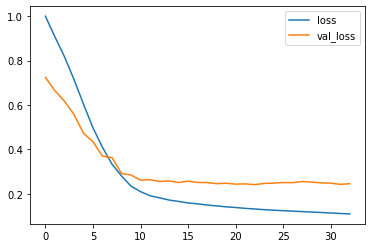

In [151]:
losses = pd.DataFrame(lstm.history.history)
#Plot out losses vs. epochs.
losses[['loss','val_loss']].plot()

7/7 [==============================] - 0s 2ms/step
Test r^2 score:  0.6826635525715097


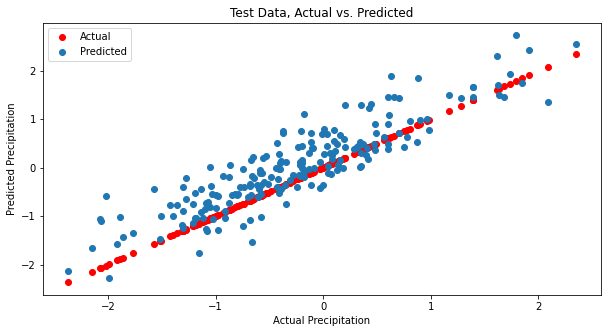

In [152]:
# Visualizing the results of actual vs. predicted precipitation
y_pred_t = lstm.predict(X_train)

plt.figure(figsize=[10, 5])

y_pred_lstm = lstm.predict(X_test)
ax = plt.subplot(1,1,1)
plt.scatter(y_test, y_test, c = 'red')
plt.scatter(y_test, y_pred_lstm)
plt.title('Test Data, Actual vs. Predicted')
plt.xlabel('Actual Precipitation')
plt.ylabel('Predicted Precipitation')
plt.legend(labels = ['Actual', 'Predicted'])


#LSTM r^2 value has improved as well, similar to RNN
print('Test r^2 score: ', r2_score(y_test, y_pred_lstm))

# Task 2: Compare performance

Now that you have built your better model, how does it compare to the example linear regression?

In [153]:
# What quantitative metrics can you use to compare model performance?

<BarContainer object of 4 artists>

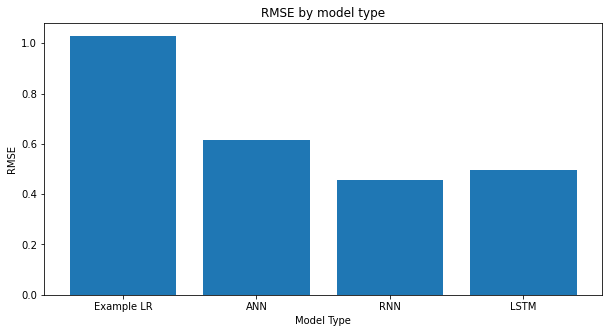

In [154]:
#Comparison of all models against each other. LSTM/ RNN have least RMSE.
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score
preds = [fit.predict(nino_oos), y_pred_ann, y_pred_rnn, y_pred_lstm]
y_tests = [precip_oos, y_test_ann, y_test, y_test]

rmse= []
ev = []
for i, j in enumerate(preds):
    rmse.append(np.sqrt(mean_squared_error(y_tests[i], j)))
    ev.append(explained_variance_score(y_tests[i], j))

labels = ['Example LR', 'ANN', 'RNN', 'LSTM']

plt.figure(figsize=[10, 5])
plt.title('RMSE by model type')
plt.ylabel('RMSE')
plt.xlabel('Model Type')
plt.bar(labels, rmse)

<BarContainer object of 4 artists>

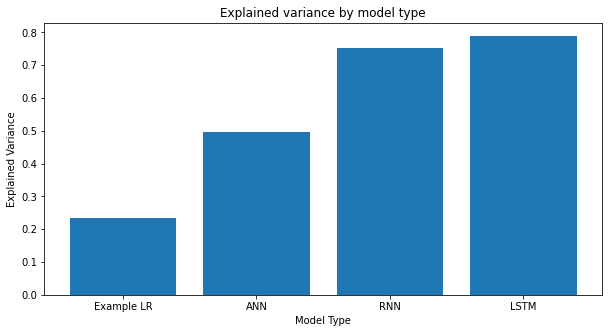

In [155]:
#Explained model variance by model. LSTM/ RNN are again the top choice.

plt.figure(figsize=[10, 5])
plt.title('Explained variance by model type')
plt.ylabel('Explained Variance')
plt.xlabel('Model Type')
plt.bar(labels, ev)

# Retrospective / Continuous Improvement

What in the task could have been clearer, smoother, or a more realistic representation of a data science workfow?

- With some more time I would usually vet the data more, performing exploratory data analysis first to understand the variance of the parameters over time, before diving into model building.
- I would have also tried to import more features that are known to affect precipitation, and perhaps done some feature engineering to try to extract more features that could improve performance.
- Using smaller or larger windows might yield better results as well. I would have usually experimented with that and noted results.
- With more time I would have tried to optimize the NN's I tested as well, changing the number of nodes, hidden layers, activation functions, etc.
- More experimentation with other ML models would provide us a good idea of how well the NN performs. With timeseries data, a classic SARIMAX model can be built to predict a variable over time, incorporate external predictors, and account for seasonalality at the same time. Experimentation with this and other models would provide a good basis to choose the correct model.